In [38]:
from graphviz import Digraph

In [39]:
class Value:
    def __init__(self, data, prev=(), op='', label=''):
        self.grad = 0

        if hasattr(data, 'data'):
            self.data = data.data
            self._prev = data.prev
            self._op = data.op
        else:
            self.data = data
            self._prev = set(prev)
            self._op = op

        self._label = label

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    @property
    def label(self):
        if not self._label and self._prev:
            return f"({[n.label for n in self._prev]})"
        return self._label

    @property
    def prev(self):
        return self._prev

    @property
    def op(self):
        return self._op


In [40]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n.op:
            dot.node(name = uid + n.op, label = n.op)
            dot.edge(uid + n.op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)

    return dot

In [41]:
a = Value(2., label='a')
b = Value(-3., label='b')
a + b

Value(data=-1.0, label=(['a', 'b']))

In [42]:
c = Value(10, label='c')
e = Value(a*b, label='e')
d = Value(e + c, label='d')
f = Value(-2., label='f')
L = Value(d * f, label='L') # Loss function
L

Value(data=-8.0, label=L)

In [43]:
a.grad = 6
b.grad = -4
e.grad = -2
c.grad = -2
d.grad = -2
f.grad = 4
L.grad = 1

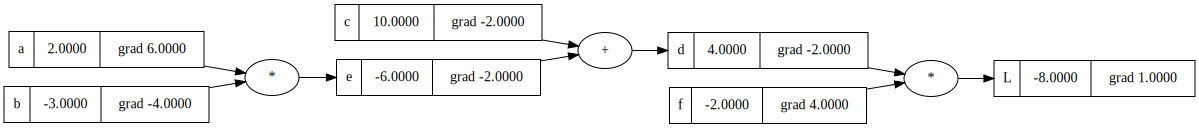

In [44]:
draw_dot(L)

In [45]:
# make L go up
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

In [46]:
# re-run forward pass
e = Value(a*b, label='e')
d = Value(e + c, label='d')
L = Value(d * f, label='L')
L.data

-7.286496

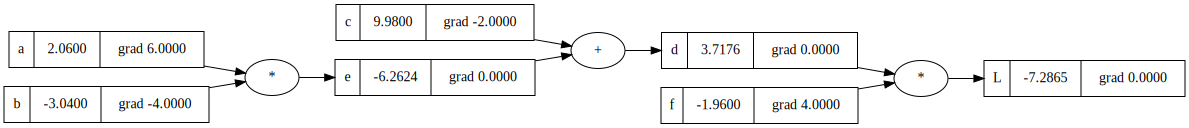

In [47]:
draw_dot(L)